# Testing ClusterDE - part 2

In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps

import os
#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Resources'
r_path = "/Library/Frameworks/R.framework/Resources/bin"
os.environ["PATH"] = r_path + ";" + os.environ["PATH"]

import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import warnings
warnings.filterwarnings("ignore")

/var/folders/c0/fpqfgc2s7f76rlp41vv8hxy1h1ttxs/T/ipykernel_97978/225857153.py:17: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [2]:
import importlib

## Preprocessing
### Read data

In [3]:
data_gene = sc.read_h5ad("../../data/MOBA_scRNAseq/outs_S3/filtered_data_maxpool_processed.h5ad")


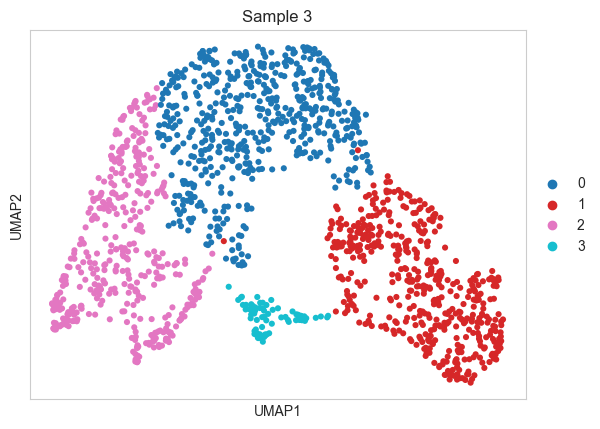

In [4]:
sc.tl.leiden(data_gene, resolution=0.15, key_added="leiden_opt", random_state=1234)
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

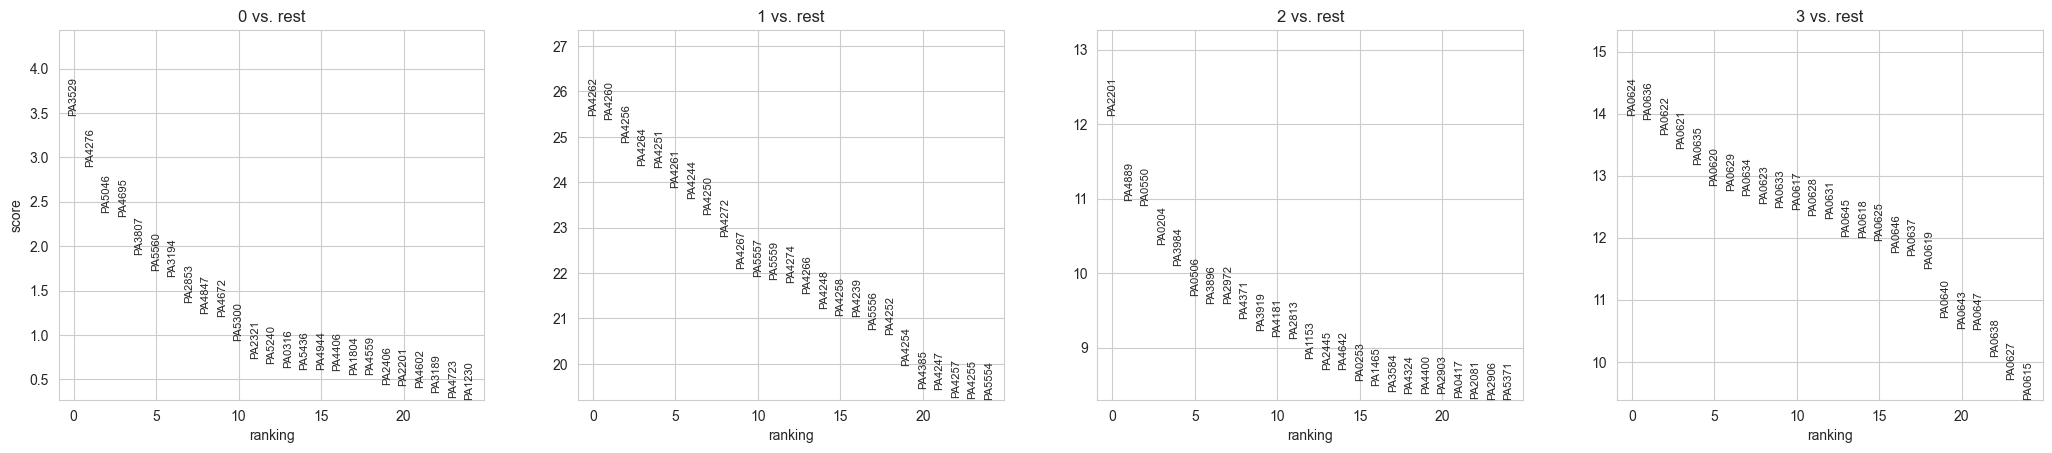

In [5]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

## Analyze synthetic null generated by scDesign

In [6]:
data_null_scd = ad.AnnData()

In [119]:
%%R -o data_null_scd

suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(SeuratDisk))
data.null <- LoadH5Seurat("../../data/MOBA_scRNAseq/outs_S3/scdesign_synthetic_null.h5Seurat")
data_null_scd <- as.SingleCellExperiment(data.null)

data_null_scd

class: SingleCellExperiment 
dim: 5553 1544 
metadata(0):
assays(2): counts logcounts
rownames(5553): PA0001 PA0002 ... PA5569 PA5570
rowData names(0):
colnames(1544): AAACCCAGTGGACCTC-1 AAACCCATCCTGTAGA-1 ...
  TTTGGTTTCGTTGTGA-1 TTTGTTGAGTAATACG-1
colData names(4): orig.ident nCount_RNA nFeature_RNA ident
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):


Validating h5Seurat file
Initializing RNA with data
Adding counts for RNA
Adding miscellaneous information for RNA
Adding command information
Adding cell-level metadata
Adding miscellaneous information
Adding tool-specific results


In [120]:
data_gene.var["var_counts"] = np.asarray(np.var(data_gene.layers["counts"].toarray(), axis=0)).squeeze()
data_gene.var["mean_counts"] = np.asarray(np.mean(data_gene.layers["counts"].toarray(), axis=0)).squeeze()

In [121]:
sc.pp.calculate_qc_metrics(data_null_scd)
data_null_scd.var["var_counts"] = np.asarray(np.var(data_null_scd.X.toarray(), axis=0)).squeeze()
data_null_scd.var["mean_counts"] = np.asarray(np.mean(data_null_scd.X.toarray(), axis=0)).squeeze()
print(data_null_scd.var)

        var_counts  mean_counts
PA0001    0.703227     0.639896
PA0002    0.581633     0.464378
PA0003    1.030034     0.873705
PA0004    0.404064     0.375000
PA0005    0.116620     0.110751
...            ...          ...
PA5566    0.007712     0.007772
PA5567    0.176024     0.132772
PA5568    0.716751     0.678756
PA5569   11.157474     3.650259
PA5570    0.839351     0.505181

[5553 rows x 2 columns]


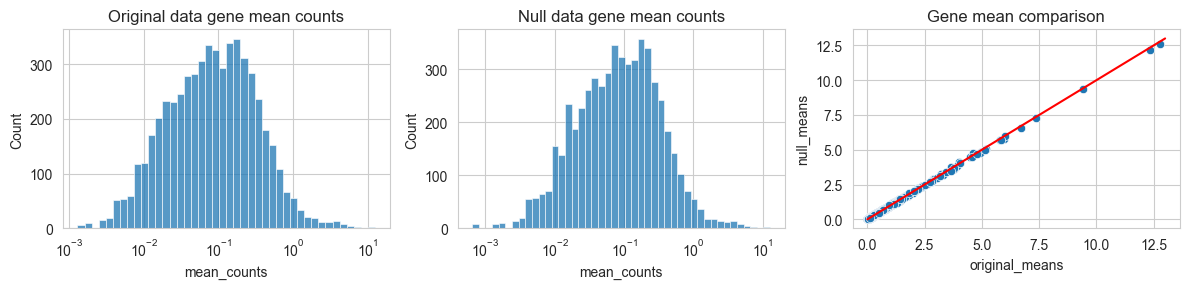

In [122]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_scd.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df = pd.DataFrame({"original_means": data_null_scd.var["mean_counts"], "null_means": data_gene.var["mean_counts"]})
sns.scatterplot(mean_df, y="null_means", x="original_means", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

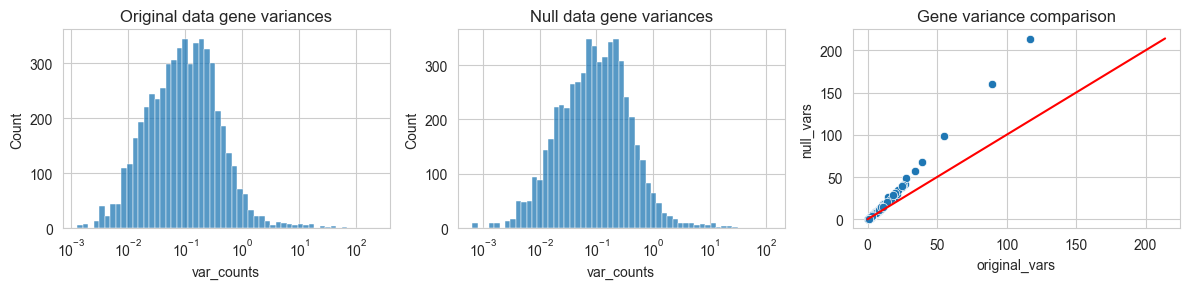

In [123]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_scd.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df = pd.DataFrame({"original_vars": data_null_scd.var["var_counts"], "null_vars": data_gene.var["var_counts"]})
sns.scatterplot(var_df, y="null_vars", x="original_vars", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene.var["var_counts"]))], [0, np.ceil(np.max(data_gene.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

In [124]:
from scipy.stats import spearmanr

cor_orig = np.corrcoef(data_gene.layers["counts"].toarray().T)
cor_orig = pd.DataFrame(cor_orig, index=data_gene.var_names, columns=data_gene.var_names)

cor_null = np.corrcoef(data_null_scd.X.toarray().T)
cor_null = pd.DataFrame(cor_null, index=data_gene.var_names, columns=data_gene.var_names)

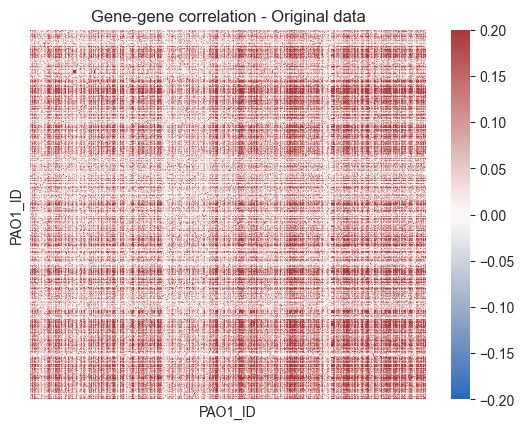

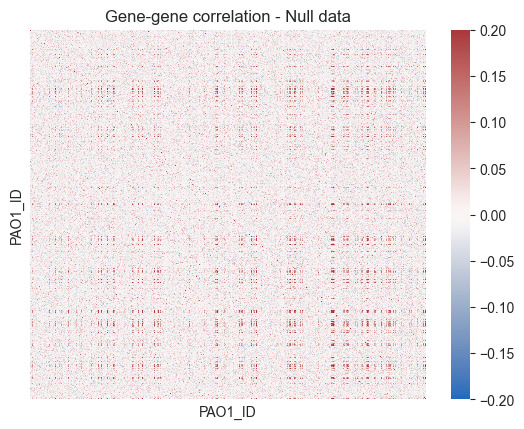

In [125]:
sns.heatmap(cor_orig,
            cmap='vlag', vmin=-0.2, vmax=0.2, center=0,
            xticklabels=False, yticklabels=False)
plt.title("Gene-gene correlation - Original data")
plt.show()

sns.heatmap(cor_null,
            cmap='vlag', vmin=-0.2, vmax=0.2, center=0,
            xticklabels=False, yticklabels=False)
plt.title("Gene-gene correlation - Null data")
plt.show()

In [126]:
R = pd.read_csv("../P_aero_S2S3/R_S3.csv", sep=",", index_col=0)
print(R)

          PA0001    PA0002    PA0003    PA0004  PA0005  PA0006  PA0007  \
PA0001  1.000000  0.213627  0.273765  0.214949       0       0       0   
PA0002  0.213627  1.000000  0.195967  0.173223       0       0       0   
PA0003  0.273765  0.195967  1.000000  0.200796       0       0       0   
PA0004  0.214949  0.173223  0.200796  1.000000       0       0       0   
PA0005  0.000000  0.000000  0.000000  0.000000       1       0       0   
...          ...       ...       ...       ...     ...     ...     ...   
PA5566  0.000000  0.000000  0.000000  0.000000       0       0       0   
PA5567  0.000000  0.000000  0.000000  0.000000       0       0       0   
PA5568  0.229032  0.173202  0.256892  0.201870       0       0       0   
PA5569  0.356460  0.248188  0.396575  0.265665       0       0       0   
PA5570  0.141626  0.108975  0.167148  0.108432       0       0       0   

          PA0008    PA0009  PA0010  ...    PA5561    PA5562    PA5563  \
PA0001  0.189605  0.177789       0  ..

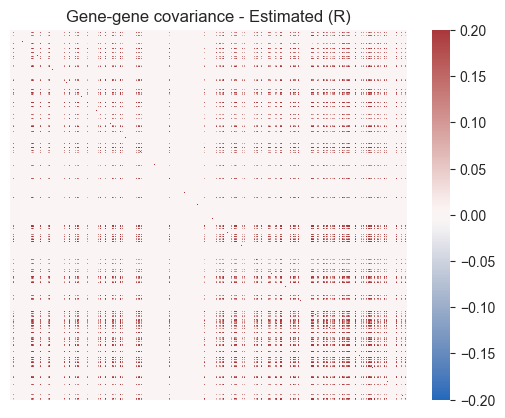

In [127]:
sns.heatmap(R,
            cmap='vlag', vmin=-0.2, vmax=0.2, center=0,
            xticklabels=False, yticklabels=False)
plt.title("Gene-gene covariance - Estimated (R)")
plt.show()

## Contrast scores

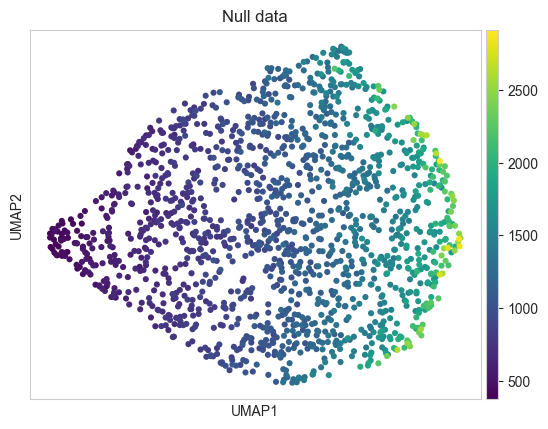

In [128]:
nb.estimate_overdisp_nb(data_null_scd, flavor="statsmod_auto")

k_opt = 3
n_neighbors_opt = 50
min_dist_opt = 0.3
res_opt = 0.15

sc.pp.calculate_qc_metrics(data_null_scd, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null_scd, target_sum=None, layer=None)
data_null_scd.X = sps.csr_matrix(np.log(data_null_scd.X.toarray() + np.array(data_null_scd.var["nb_overdisp_cutoff"] / 4)))
data_null_scd.layers["vst_counts"] = data_null_scd.X.copy()
sc.pp.scale(data_null_scd, max_value=10, zero_center=True)
data_null_scd.X[np.isnan(data_null_scd.X)] = 0
sc.tl.pca(data_null_scd, svd_solver='arpack')
sc.pp.neighbors(data_null_scd, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null_scd, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)
sc.pl.umap(data_null_scd, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()

In [129]:
res2 = 0.05
twoclust = False

while twoclust is False:
    res2 += 0.01
    sc.tl.leiden(data_null_scd, resolution=res2, key_added="leiden", random_state=None)
    nclust = len(data_null_scd.obs["leiden"].unique())
    if nclust == 2:
        twoclust = True
    
    
print(f"Resolution for two clusters: {res2}")

Resolution for two clusters: 0.09999999999999999


In [191]:
sc.tl.rank_genes_groups(data_null_scd, groupby='leiden', method='wilcoxon')
p_null_s3 = pd.DataFrame({"pval_null": [x[1] for x in data_null_scd.uns["rank_genes_groups"]["pvals"]]},
                         index=[x[1] for x in data_null_scd.uns["rank_genes_groups"]["names"]])

clusters = data_gene.obs["leiden_opt"].unique()

DEs_log = {}
pvals_log = {}
fdr = 0.1

for c in clusters:
    print(c)
    p_data = pd.DataFrame(
        {"pval_data": [x[c] for x in data_gene.uns[f"rank_genes_groups"]["pvals"]]},
        index=[x[c] for x in data_gene.uns[f"rank_genes_groups"]["names"]]
    )
    DE_TU, pval_TU = cd.call_de(p_data, p_null_s3, FDR=fdr, correct=False, nlog=True)
    data_gene.var[f"pval_cluster_{c}"] = pval_TU["pval_data"]
    data_gene.var[f"q_cluster_{c}"] = pval_TU["q"]
    data_gene.var[f"DE_cluster_{c}"] = (data_gene.var[f"q_cluster_{c}"] < fdr)
    
    DEs_log[c] = DE_TU
    pvals_log[c] = pval_TU
    print(f"DE genes: {len(DEs_log[c])}")

0
DE genes: 0
1
DE genes: 32
2
DE genes: 0
3
DE genes: 0


In [192]:
DEs = {}
pvals = {}
fdr = 0.1

for c in clusters:
    print(c)
    p_data = pd.DataFrame(
        {"pval_data": [x[c] for x in data_gene.uns[f"rank_genes_groups"]["pvals"]]},
        index=[x[c] for x in data_gene.uns[f"rank_genes_groups"]["names"]]
    )
    DE_TU, pval_TU = cd.call_de(p_data, p_null_s3, FDR=fdr, correct=False, nlog=False)
    data_gene.var[f"pval_cluster_{c}"] = pval_TU["pval_data"]
    data_gene.var[f"q_cluster_{c}"] = pval_TU["q"]
    data_gene.var[f"DE_cluster_{c}"] = (data_gene.var[f"q_cluster_{c}"] < fdr)
    
    DEs[c] = DE_TU
    pvals[c] = pval_TU
    print(f"DE genes: {len(DEs[c])}")

0
DE genes: 0
1
DE genes: 0
2
DE genes: 0
3
DE genes: 0


In [193]:
from scipy.stats import ranksums

X_null_scd_0 = data_null_scd.X[data_null_scd.obs["leiden"] == "0"]
X_null_scd_1 = data_null_scd.X[data_null_scd.obs["leiden"] != "0"]

pval_null_scd = pd.DataFrame({"pval_null": ranksums(X_null_scd_0, X_null_scd_1, alternative="two-sided").pvalue}, index=data_null_scd.var.index)
print(pval_null_scd)

           pval_null
PA0001  6.442722e-15
PA0002  3.237412e-08
PA0003  1.757711e-14
PA0004  1.800561e-06
PA0005  3.585474e-01
...              ...
PA5566  9.646710e-01
PA5567  7.373337e-01
PA5568  8.802847e-11
PA5569  1.863905e-61
PA5570  5.356627e-09

[5553 rows x 1 columns]


In [194]:
DEs_man = {}
pvals_man = {}
fdr = 0.1

for c in clusters:
    X_data_0 = data_gene.X[data_gene.obs["leiden_opt"] == c]
    X_data_1 = data_gene.X[data_gene.obs["leiden_opt"] != c]
    p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene.var.index)
    DE, pval = cd.call_de(p_data, pval_null_scd, FDR=fdr, correct=False, nlog=False)
    data_gene.var[f"pval_cluster_{c}_man"] = pval["pval_data"]
    data_gene.var[f"q_cluster_{c}_man"] = pval["q"]
    data_gene.var[f"DE_cluster_{c}_man"] = (data_gene.var[f"q_cluster_{c}_man"] < fdr)
    
    DEs_man[c] = DE
    pvals_man[c] = pval
    print(f"Cluster {c} - DE genes: {len(DEs_man[c])}")

Cluster 0 - DE genes: 0
Cluster 1 - DE genes: 0
Cluster 2 - DE genes: 0
Cluster 3 - DE genes: 0


In [195]:
DEs_man_log = {}
pvals_man_log  = {}
fdr = 0.1

for c in clusters:
    X_data_0 = data_gene.X[data_gene.obs["leiden_opt"] == c]
    X_data_1 = data_gene.X[data_gene.obs["leiden_opt"] != c]
    p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene.var.index)
    DE, pval = cd.call_de(p_data, pval_null_scd, FDR=fdr, correct=False, nlog=True)
    data_gene.var[f"pval_cluster_{c}_man"] = pval["pval_data"]
    data_gene.var[f"q_cluster_{c}_man"] = pval["q"]
    data_gene.var[f"DE_cluster_{c}_man"] = (data_gene.var[f"q_cluster_{c}_man"] < fdr)
    
    DEs_man_log [c] = DE
    pvals_man_log [c] = pval
    print(f"Cluster {c} - DE genes: {len(DEs_man_log [c])}")

Cluster 0 - DE genes: 0
Cluster 1 - DE genes: 32
Cluster 2 - DE genes: 0
Cluster 3 - DE genes: 0


Empty DataFrame
Columns: [pval_data, pval_null, cs, q]
Index: []


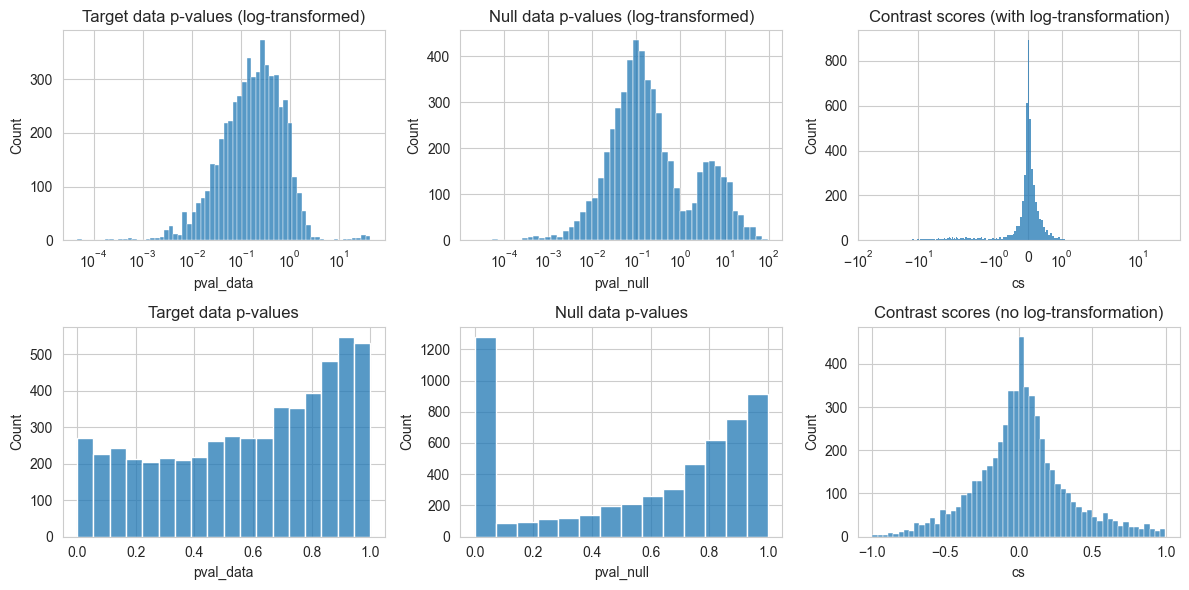

In [196]:
c = "3"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_man_log[c], x="pval_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_man_log[c], x="pval_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_man_log[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog")

sns.histplot(pvals_man[c], x="pval_data", ax=ax[1,0])
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_man[c], x="pval_null", ax=ax[1,1])
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_man[c], x="cs", ax=ax[1,2])
ax[1,2].set_title("Contrast scores (no log-transformation)")

print(DEs_man[c])


plt.tight_layout()
plt.show()

        pval_data     pval_null        cs         q
PA2615   0.998721  1.302536e-03  0.997418  0.095238
PA5214   0.996162  3.609390e-18  0.996162  0.095238
PA4846   0.992325  1.282868e-12  0.992325  0.095238
PA3812   0.988701  8.792118e-15  0.988701  0.095238
PA0085   0.988274  2.706494e-11  0.988274  0.095238
PA1294   0.988487  1.038754e-03  0.987449  0.095238
PA2974   0.984544  1.146205e-08  0.984544  0.095238
PA3635   0.981666  4.008992e-06  0.981662  0.095238
PA2645   0.979428  1.933461e-12  0.979428  0.095238
PA1475   0.978043  8.400770e-04  0.977203  0.095238
PA4759   0.974314  2.560529e-10  0.974314  0.095238
PA0046   0.973887  9.765233e-07  0.973886  0.095238
PA4275   0.973142  1.309076e-14  0.973142  0.095238
PA3148   0.973035  3.217359e-06  0.973032  0.095238
PA0549   0.971544  7.066317e-04  0.970837  0.095238
PA5007   0.967922  3.199890e-04  0.967602  0.095238
PA1069   0.966857  1.060552e-05  0.966846  0.095238
PA5013   0.959509  5.451969e-17  0.959509  0.095238
PA5052   0.9

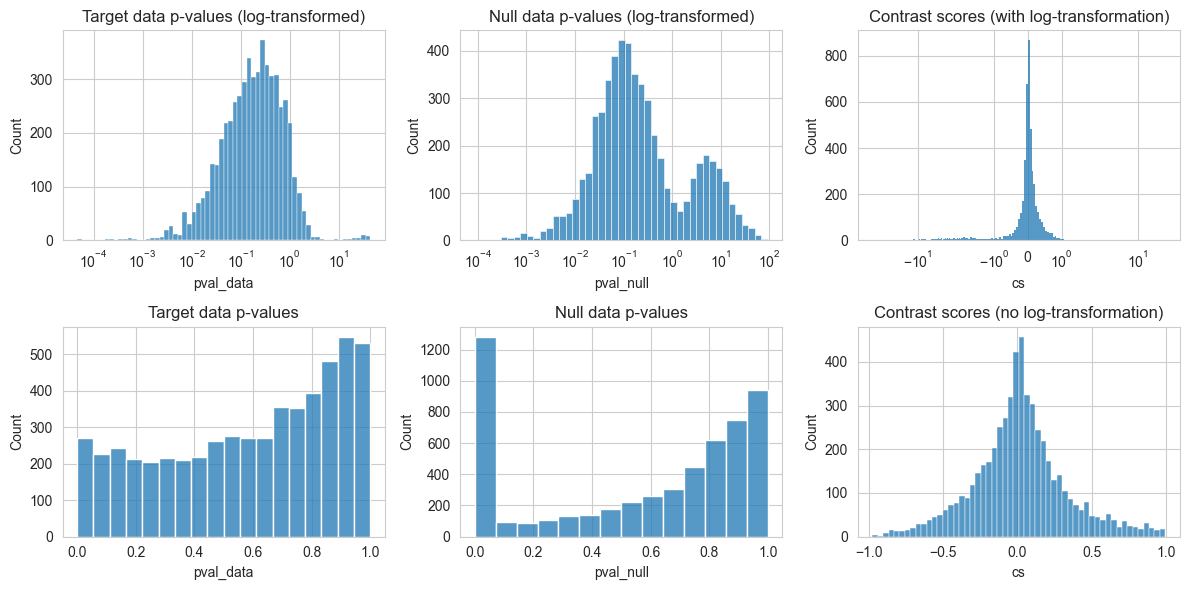

In [52]:
c = "3"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log[c], x="pval_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log[c], x="pval_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog")

sns.histplot(pvals[c], x="pval_data", ax=ax[1,0])
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals[c], x="pval_null", ax=ax[1,1])
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals[c], x="cs", ax=ax[1,2])
ax[1,2].set_title("Contrast scores (no log-transformation)")

print(DEs[c])


plt.tight_layout()
plt.show()

In [53]:
pvals_out = pvals["3"]

pvals_out["pval_data_log"] = pvals_log["3"]["pval_data"]
pvals_out["pval_null_log"] = pvals_log["3"]["pval_null"]
pvals_out["cs_log"] = pvals_log["3"]["cs"]
pvals_out["q_log"] = pvals_log["3"]["q"]

pvals_out.to_csv("pvals_3")

Empty DataFrame
Columns: [pval_data, pval_null, cs, q]
Index: []


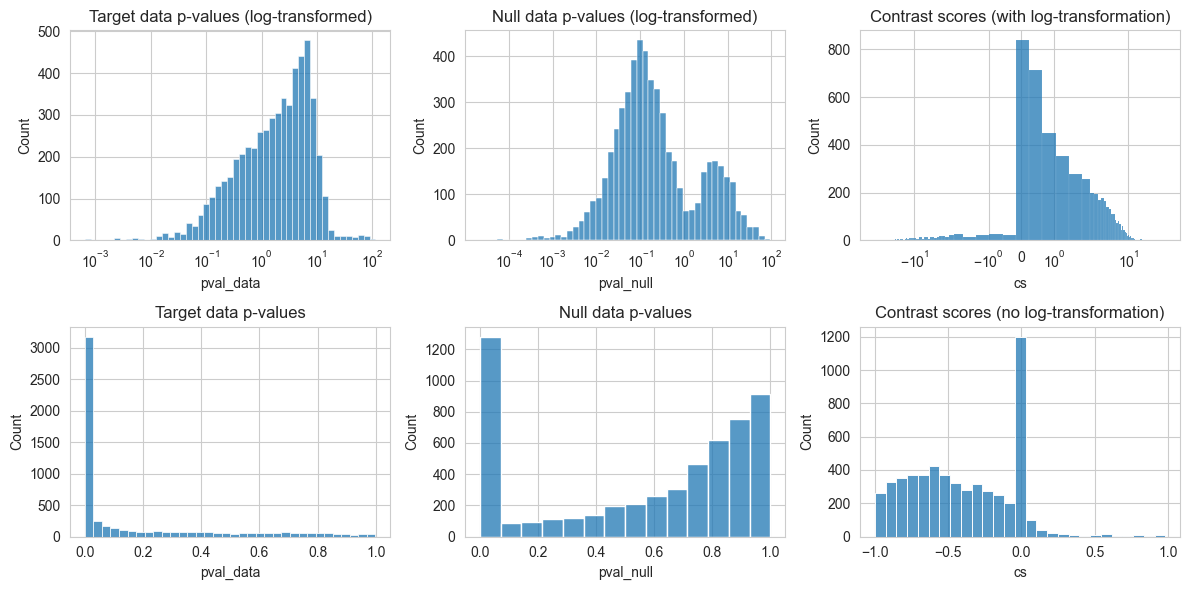

In [201]:
c = "2"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log[c], x="pval_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log[c], x="pval_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog")

sns.histplot(pvals[c], x="pval_data", ax=ax[1,0])
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals[c], x="pval_null", ax=ax[1,1])
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals[c], x="cs", ax=ax[1,2])
ax[1,2].set_title("Contrast scores (no log-transformation)")

print(DEs[c])


plt.tight_layout()
plt.show()

In [55]:
pvals

{'0':         pval_data     pval_null        cs    q
 PA5253   0.991507  3.904990e-21  0.991507  1.0
 PA4669   0.990988  4.064174e-22  0.990988  1.0
 PA4889   0.987543  4.412389e-04  0.987102  1.0
 PA3744   0.972354  2.108533e-42  0.972354  1.0
 PA5435   0.952087  1.478301e-17  0.952087  1.0
 ...           ...           ...       ...  ...
 PA1367   0.005822  9.981173e-01 -0.992295  1.0
 PA5347   0.001469  9.951941e-01 -0.993726  1.0
 PA0833   0.000470  9.979686e-01 -0.997499  1.0
 PA3955   0.000051  9.977704e-01 -0.997719  1.0
 PA3153   0.001148  9.989100e-01 -0.997762  1.0
 
 [5553 rows x 4 columns],
 '1':         pval_data     pval_null        cs    q
 PA2826   0.999951  2.465603e-04  0.999704  0.5
 PA4636   0.997692  3.059730e-05  0.997661  0.5
 PA0410   0.997299  3.581990e-07  0.997298  0.5
 PA1293   0.997397  4.862653e-04  0.996911  0.5
 PA5278   0.996415  2.076420e-10  0.996415  0.5
 ...           ...           ...       ...  ...
 PA2025   0.000153  9.913296e-01 -0.991177  1.0
 P

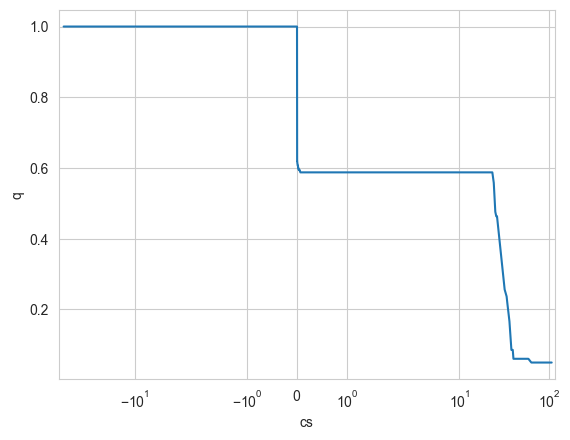

In [56]:
sns.lineplot(data=pvals_log[c], x="cs", y="q")
plt.xscale("symlog")
plt.show()

## Reimplement simplified version

In [39]:
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="BFGS")
data_gene.var["nb_overdisp_cutoff_bfgs"] = data_gene.var["nb_overdisp_cutoff"]
data_gene.var["nb_overdisp_bfgs"] = data_gene.var["nb_overdisp"]
data_gene.var["nb_mean_bfgs"] = data_gene.var["nb_mean"]
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="sctransform")


Fitting feature 100/5553
Fitting feature 200/5553
Fitting feature 300/5553
Fitting feature 400/5553
Fitting feature 500/5553
Fitting feature 600/5553
Fitting feature 700/5553
Fitting feature 800/5553
Fitting feature 900/5553
Fitting feature 1000/5553
Fitting feature 1100/5553
Fitting feature 1200/5553
Fitting feature 1300/5553
Fitting feature 1400/5553
Fitting feature 1500/5553
Fitting feature 1600/5553
Fitting feature 1700/5553
Fitting feature 1800/5553
Fitting feature 1900/5553
Fitting feature 2000/5553
Fitting feature 2100/5553
Fitting feature 2200/5553
Fitting feature 2300/5553
Fitting feature 2400/5553
Fitting feature 2500/5553
Fitting feature 2600/5553
Fitting feature 2700/5553
Fitting feature 2800/5553
Fitting feature 2900/5553
Fitting feature 3000/5553
Fitting feature 3100/5553
Fitting feature 3200/5553
Fitting feature 3300/5553
Fitting feature 3400/5553
Fitting feature 3500/5553
Fitting feature 3600/5553
Fitting feature 3700/5553
Fitting feature 3800/5553
Fitting feature 3900/

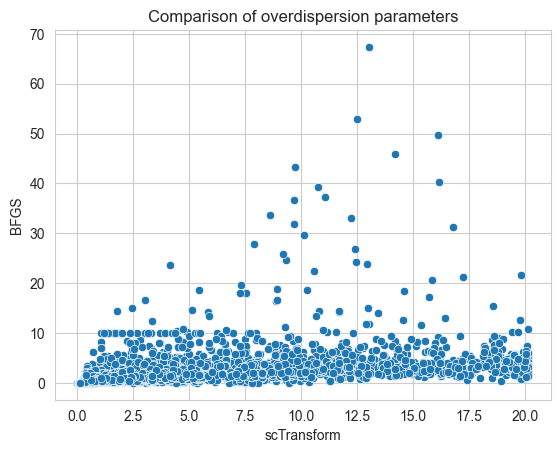

In [40]:
g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff_bfgs", x="nb_overdisp_cutoff")
plt.title("Comparison of overdispersion parameters")
plt.xlabel("scTransform")
plt.ylabel("BFGS")
plt.show()

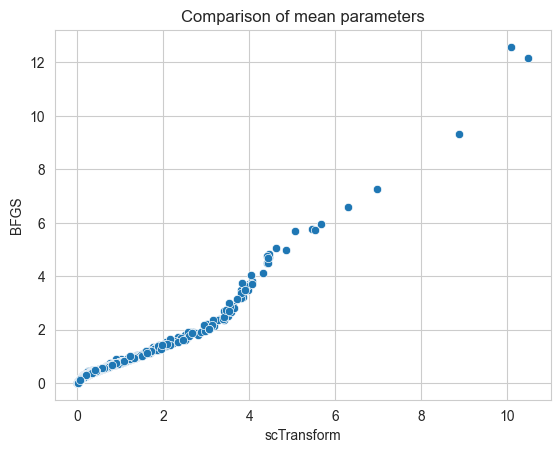

In [44]:
data_gene.var["nb_mean_trafo"] = np.exp(data_gene.var["nb_mean"])*1000
g = sns.scatterplot(data=data_gene.var, y="nb_mean_bfgs", x="nb_mean_trafo")
plt.title("Comparison of mean parameters")
plt.xlabel("scTransform")
plt.ylabel("BFGS")
plt.show()

In [54]:
from scipy.stats import nbinom, norm

nb_means = data_gene.var["nb_mean_bfgs"]
nb_overdisps = data_gene.var["nb_overdisp_bfgs"]
X = data_gene.layers["counts"].copy().toarray().astype(int)

r, p = nb.negbin_mean_to_numpy(nb_means, nb_overdisps)
r = r.tolist()
p = p.tolist()

r2, p2 = nb.negbin_mean_to_numpy(data_gene.var["nb_mean_trafo"], data_gene.var["nb_overdisp"])
r2 = r2.tolist()
p2 = p2.tolist()

# print(r)
# print(p)

F = np.array([nbinom.cdf(X[:, j], r[j], p[j]) for j in range(X.shape[1])]).T
F1 = np.array([nbinom.cdf(X[:, j] + 1, r[j], p[j]) for j in range(X.shape[1])]).T

print(F)
print(F1)

[[0.53277791 0.65494137 0.43411381 ... 0.53392422 0.31054574 0.6903714 ]
 [0.53277791 0.65494137 0.77283348 ... 0.85274467 0.89137058 0.6903714 ]
 [0.85005185 0.65494137 0.43411381 ... 0.53392422 0.14069672 0.6903714 ]
 ...
 [0.53277791 0.65494137 0.43411381 ... 0.53392422 0.31054574 0.6903714 ]
 [0.53277791 0.65494137 0.77283348 ... 0.53392422 0.14069672 0.6903714 ]
 [0.53277791 0.90595319 0.77283348 ... 0.85274467 0.84723609 0.6903714 ]]
[[0.85005185 0.90595319 0.77283348 ... 0.85274467 0.46868315 0.89673015]
 [0.85005185 0.90595319 0.92648864 ... 0.96311236 0.92332098 0.89673015]
 [0.96140853 0.90595319 0.77283348 ... 0.85274467 0.31054574 0.89673015]
 ...
 [0.85005185 0.90595319 0.77283348 ... 0.85274467 0.46868315 0.89673015]
 [0.85005185 0.90595319 0.92648864 ... 0.85274467 0.31054574 0.89673015]
 [0.85005185 0.9769798  0.92648864 ... 0.96311236 0.89137058 0.89673015]]


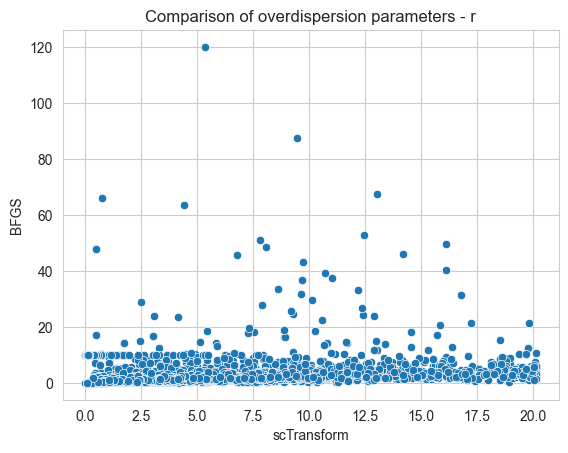

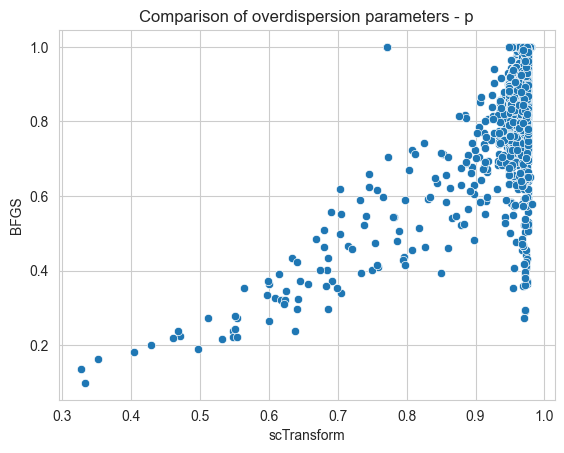

In [55]:
rp_data = pd.DataFrame({"r_bfgs": r, "p_bfgs": p, "r_sct": r2, "p_sct": p2})
g = sns.scatterplot(data=rp_data, y="r_bfgs", x="r_sct")
plt.title("Comparison of overdispersion parameters - r")
plt.xlabel("scTransform")
plt.ylabel("BFGS")
plt.show()

g = sns.scatterplot(data=rp_data, y="p_bfgs", x="p_sct")
plt.title("Comparison of overdispersion parameters - p")
plt.xlabel("scTransform")
plt.ylabel("BFGS")
plt.show()

In [56]:
rng = np.random.default_rng(1234)
V = rng.uniform(0, 1, F.shape)

U = V * F + (1 - V) * F1


In [57]:
U_inv = norm.ppf(U, 0, 1)
R_est = np.corrcoef(U_inv.T)
R_est[R_est < 0] = 0
R_est = pd.DataFrame(R_est, index=data_gene.var_names, columns=data_gene.var_names)

In [58]:
Z = rng.multivariate_normal(mean=np.zeros(X.shape[1]), cov=R_est, size=X.shape[0])

In [59]:
Z_cdf = norm.cdf(Z)

Y_gen = np.array([nbinom.ppf(Z_cdf[:, j], r[j], p[j]) for j in range(X.shape[1])]).T

In [60]:
data_null_gen = ad.AnnData(X=Y_gen, obs=pd.DataFrame(index=data_gene.obs.index), var=pd.DataFrame(index=data_gene.var.index))


In [61]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

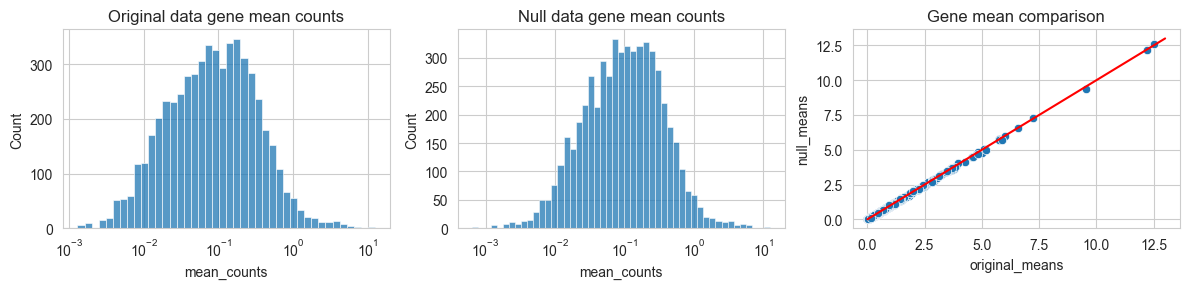

In [62]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df = pd.DataFrame({"original_means": data_null_gen.var["mean_counts"], "null_means": data_gene.var["mean_counts"]})
sns.scatterplot(mean_df, y="null_means", x="original_means", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

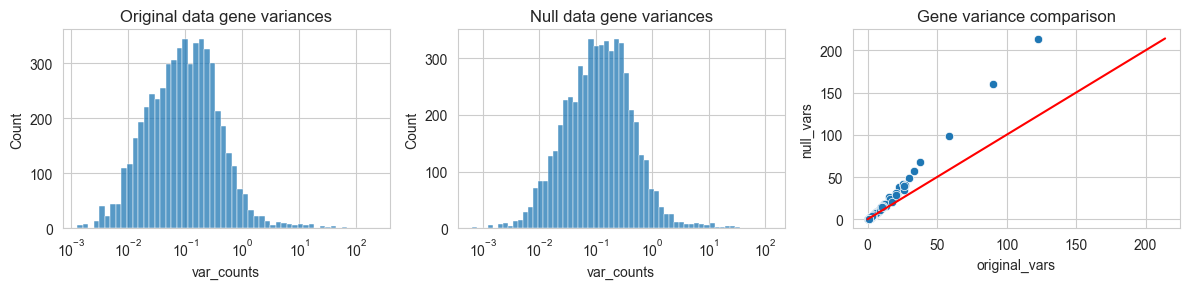

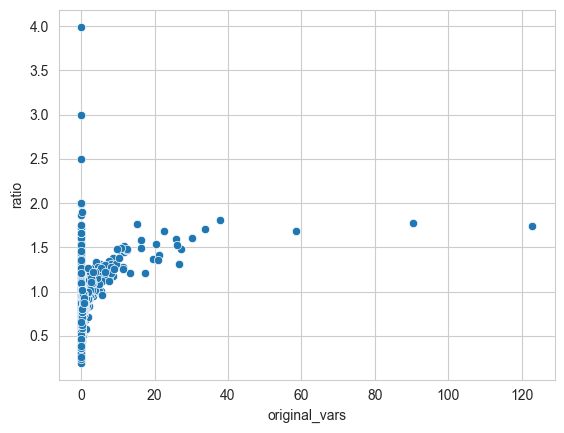

In [63]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df = pd.DataFrame({"original_vars": data_null_gen.var["var_counts"], "null_vars": data_gene.var["var_counts"]})
var_df["ratio"] = var_df["null_vars"] / var_df["original_vars"]
sns.scatterplot(var_df, y="null_vars", x="original_vars", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene.var["var_counts"]))], [0, np.ceil(np.max(data_gene.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

sns.scatterplot(var_df, x="original_vars", y="ratio")
plt.show()

In [64]:
cor_gen = np.corrcoef(data_null_gen.X.T)
cor_gen = pd.DataFrame(cor_gen, index=data_gene.var_names, columns=data_gene.var_names)

sns.heatmap(cor_orig,
            cmap='vlag', vmin=-0.2, vmax=0.2, center=0,
            xticklabels=False, yticklabels=False)
plt.title("Gene-gene correlation - Original data")
plt.show()

sns.heatmap(cor_gen,
            cmap='vlag', vmin=-0.2, vmax=0.2, center=0,
            xticklabels=False, yticklabels=False)
plt.title("Gene-gene correlation - Null data")
plt.show()

NameError: name 'cor_orig' is not defined

In [ ]:
all_cors = pd.DataFrame({"cor_orig": cor_orig.values.flatten(), "cor_gen": cor_gen.values.flatten(), "cor_null": cor_null.values.flatten()})
print(all_cors)

In [ ]:
ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]
print(all_cors_subset)

In [ ]:
sns.scatterplot(all_cors_subset[all_cors_subset['cor_orig'] < 0.99], x="cor_orig", y="cor_gen", s=1, color="black")
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_orig']))], [0, np.ceil(np.max(all_cors_subset['cor_orig']))], color="red")
plt.show()

In [ ]:
sns.scatterplot(all_cors_subset[all_cors_subset['cor_orig'] < 0.99], x="cor_orig", y="cor_null", s=1, color="black")
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_orig']))], [0, np.ceil(np.max(all_cors_subset['cor_orig']))], color="red")
plt.show()

### process newly generated data

In [ ]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_null_gen)

k_opt = 3
n_neighbors_opt = 50
min_dist_opt = 0.3
res_opt = 0.15

sc.pp.calculate_qc_metrics(data_null_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null_gen, target_sum=None, layer=None)
data_null_gen.X = sps.csr_matrix(np.log(data_null_gen.X + np.array(data_null_gen.var["nb_overdisp_cutoff"] / 4)))
data_null_gen.layers["vst_counts"] = data_null_gen.X.copy()
sc.pp.scale(data_null_gen, max_value=10, zero_center=True)
data_null_gen.X[np.isnan(data_null_gen.X)] = 0
sc.tl.pca(data_null_gen, svd_solver='arpack')
sc.pp.neighbors(data_null_gen, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null_gen, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)
sc.pl.umap(data_null_gen, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()

In [ ]:
res2 = 0.05
twoclust = False

while twoclust is False:
    res2 += 0.01
    sc.tl.leiden(data_null_gen, resolution=res2, key_added="leiden", random_state=None)
    nclust = len(data_null_gen.obs["leiden"].unique())
    if nclust == 2:
        twoclust = True
    
    
print(f"Resolution for two clusters: {res2}")

In [ ]:
X_null_gen_0 = data_null_gen.X[data_null_gen.obs["leiden"] == "0"]
X_null_gen_1 = data_null_gen.X[data_null_gen.obs["leiden"] != "0"]

pval_null_gen = pd.DataFrame({"pval_null": ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue}, index=data_null_gen.var.index)

clusters = data_gene.obs["leiden_opt"].unique()

DEs_log_gen = {}
pvals_log_gen = {}
fdr = 0.1

for c in clusters:
    X_data_0 = data_gene.X[data_gene.obs["leiden_opt"] == c]
    X_data_1 = data_gene.X[data_gene.obs["leiden_opt"] != c]
    p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene.var.index)
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
    data_gene.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene.var[f"DE_cluster_{c}_gen"] = (data_gene.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_log_gen[c] = DE_TU
    pvals_log_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_log_gen[c])}")

In [ ]:
DEs_gen = {}
pvals_gen = {}
fdr = 0.1

for c in clusters:
    X_data_0 = data_gene.X[data_gene.obs["leiden_opt"] == c]
    X_data_1 = data_gene.X[data_gene.obs["leiden_opt"] != c]
    p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene.var.index)
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=False)
    data_gene.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene.var[f"DE_cluster_{c}_gen"] = (data_gene.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_gen[c] = DE_TU
    pvals_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_gen[c])}")

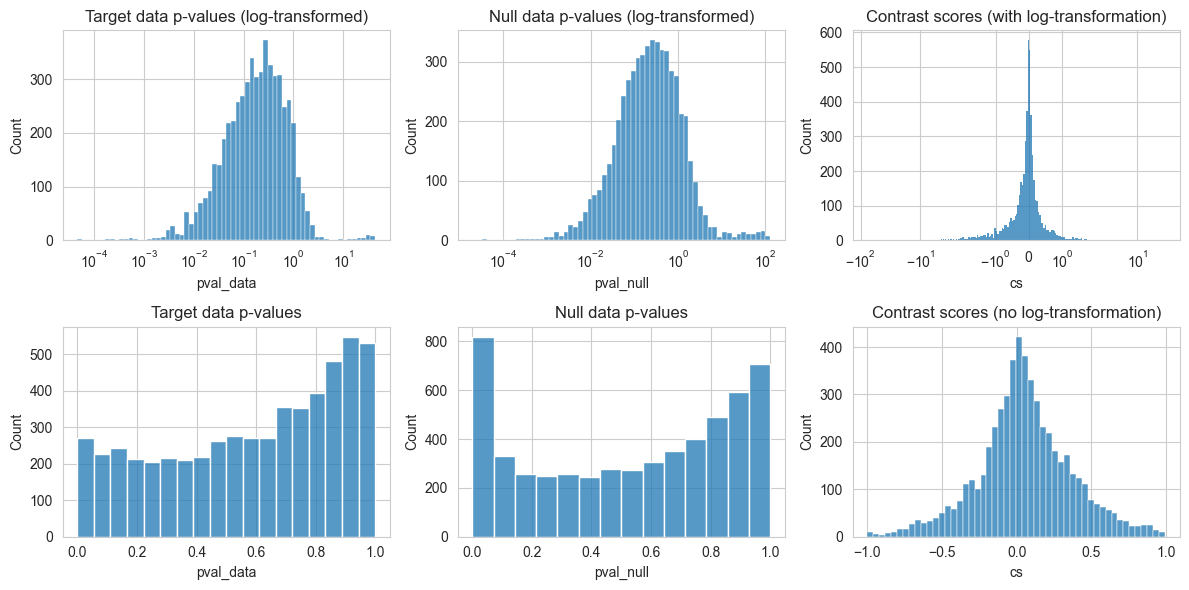

In [189]:
c = "3"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog")

sns.histplot(pvals_gen[c], x="pval_data", ax=ax[1,0])
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_gen[c], x="pval_null", ax=ax[1,1])
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_gen[c], x="cs", ax=ax[1,2])
ax[1,2].set_title("Contrast scores (no log-transformation)")


plt.tight_layout()
plt.show()

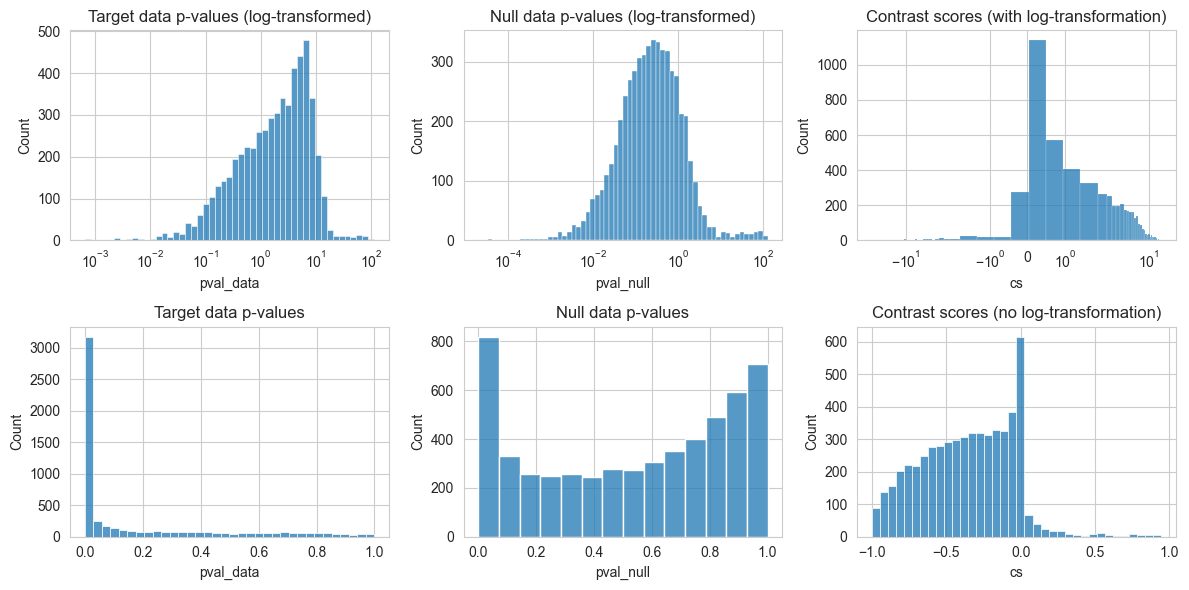

In [190]:
c = "2"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog")

sns.histplot(pvals_gen[c], x="pval_data", ax=ax[1,0])
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_gen[c], x="pval_null", ax=ax[1,1])
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_gen[c], x="cs", ax=ax[1,2])
ax[1,2].set_title("Contrast scores (no log-transformation)")


plt.tight_layout()
plt.show()

In [5]:
data_gene

AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'PAO1_ID', 'TU_ID', 'Regulation - transcription units of gene', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs', 'is_scd_outlier', 'mean', 'std'
    uns: 'embedding_reliability_colors', 'leiden', 'leiden_opt_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'
    obsp: 'connectivities', 'distances'

In [14]:
rng=np.random.default_rng(1234)
all_vst_counts = data_gene.layers["vst_counts"].toarray().flatten()
ids = rng.choice(len(all_vst_counts), 100000, replace=False)
all_vst_counts_subset = all_vst_counts[ids]

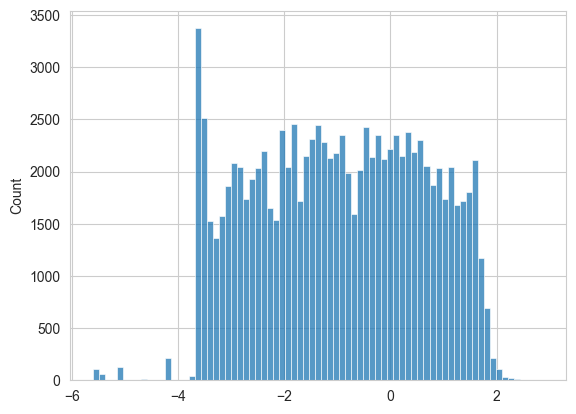

In [15]:
sns.histplot(all_vst_counts_subset)
plt.show()